# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Подключение библиотек

In [1]:
! pip install phik -q
#! pip install shap -q
#! pip install scikit-learn==1.2.2 -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = np.random.RandomState(12345)

### Функции вывода графиков

In [3]:
def plots_hist_box(df):
    numeric_cols = df.select_dtypes(include=['number']).columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(15, 5*num_plots))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        if len(df[col].unique()) > 15:
            df[col].hist(bins=15)
        else:
            sns.countplot(df[col])
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Количество значений')

        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Распределение {col}')

    plt.tight_layout()
    plt.show()
    
def plots_pie(df):
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    num_plots = len(categorical_cols)
    plt.figure(figsize=(12, 5 * num_plots))

    for i, col in enumerate(categorical_cols):
        plt.subplot(num_plots, 1, i + 1)
        plt.pie(df[col].value_counts(), autopct = '%1.1f%%', labels=df[col].sort_values().unique())
        plt.title(f'Соотношение {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

### Загрузка данных

In [4]:
geo_data_0 = pd.read_csv('./datasets/geo_data_0.csv')
geo_data_0.info()
display(geo_data_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_1 = pd.read_csv('./datasets/geo_data_1.csv')
geo_data_1.info()
display(geo_data_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_2 = pd.read_csv('./datasets/geo_data_2.csv')
geo_data_2.info()
display(geo_data_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Проверка на наличие пропусков

In [7]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков не обнаружено

### Анализ данных

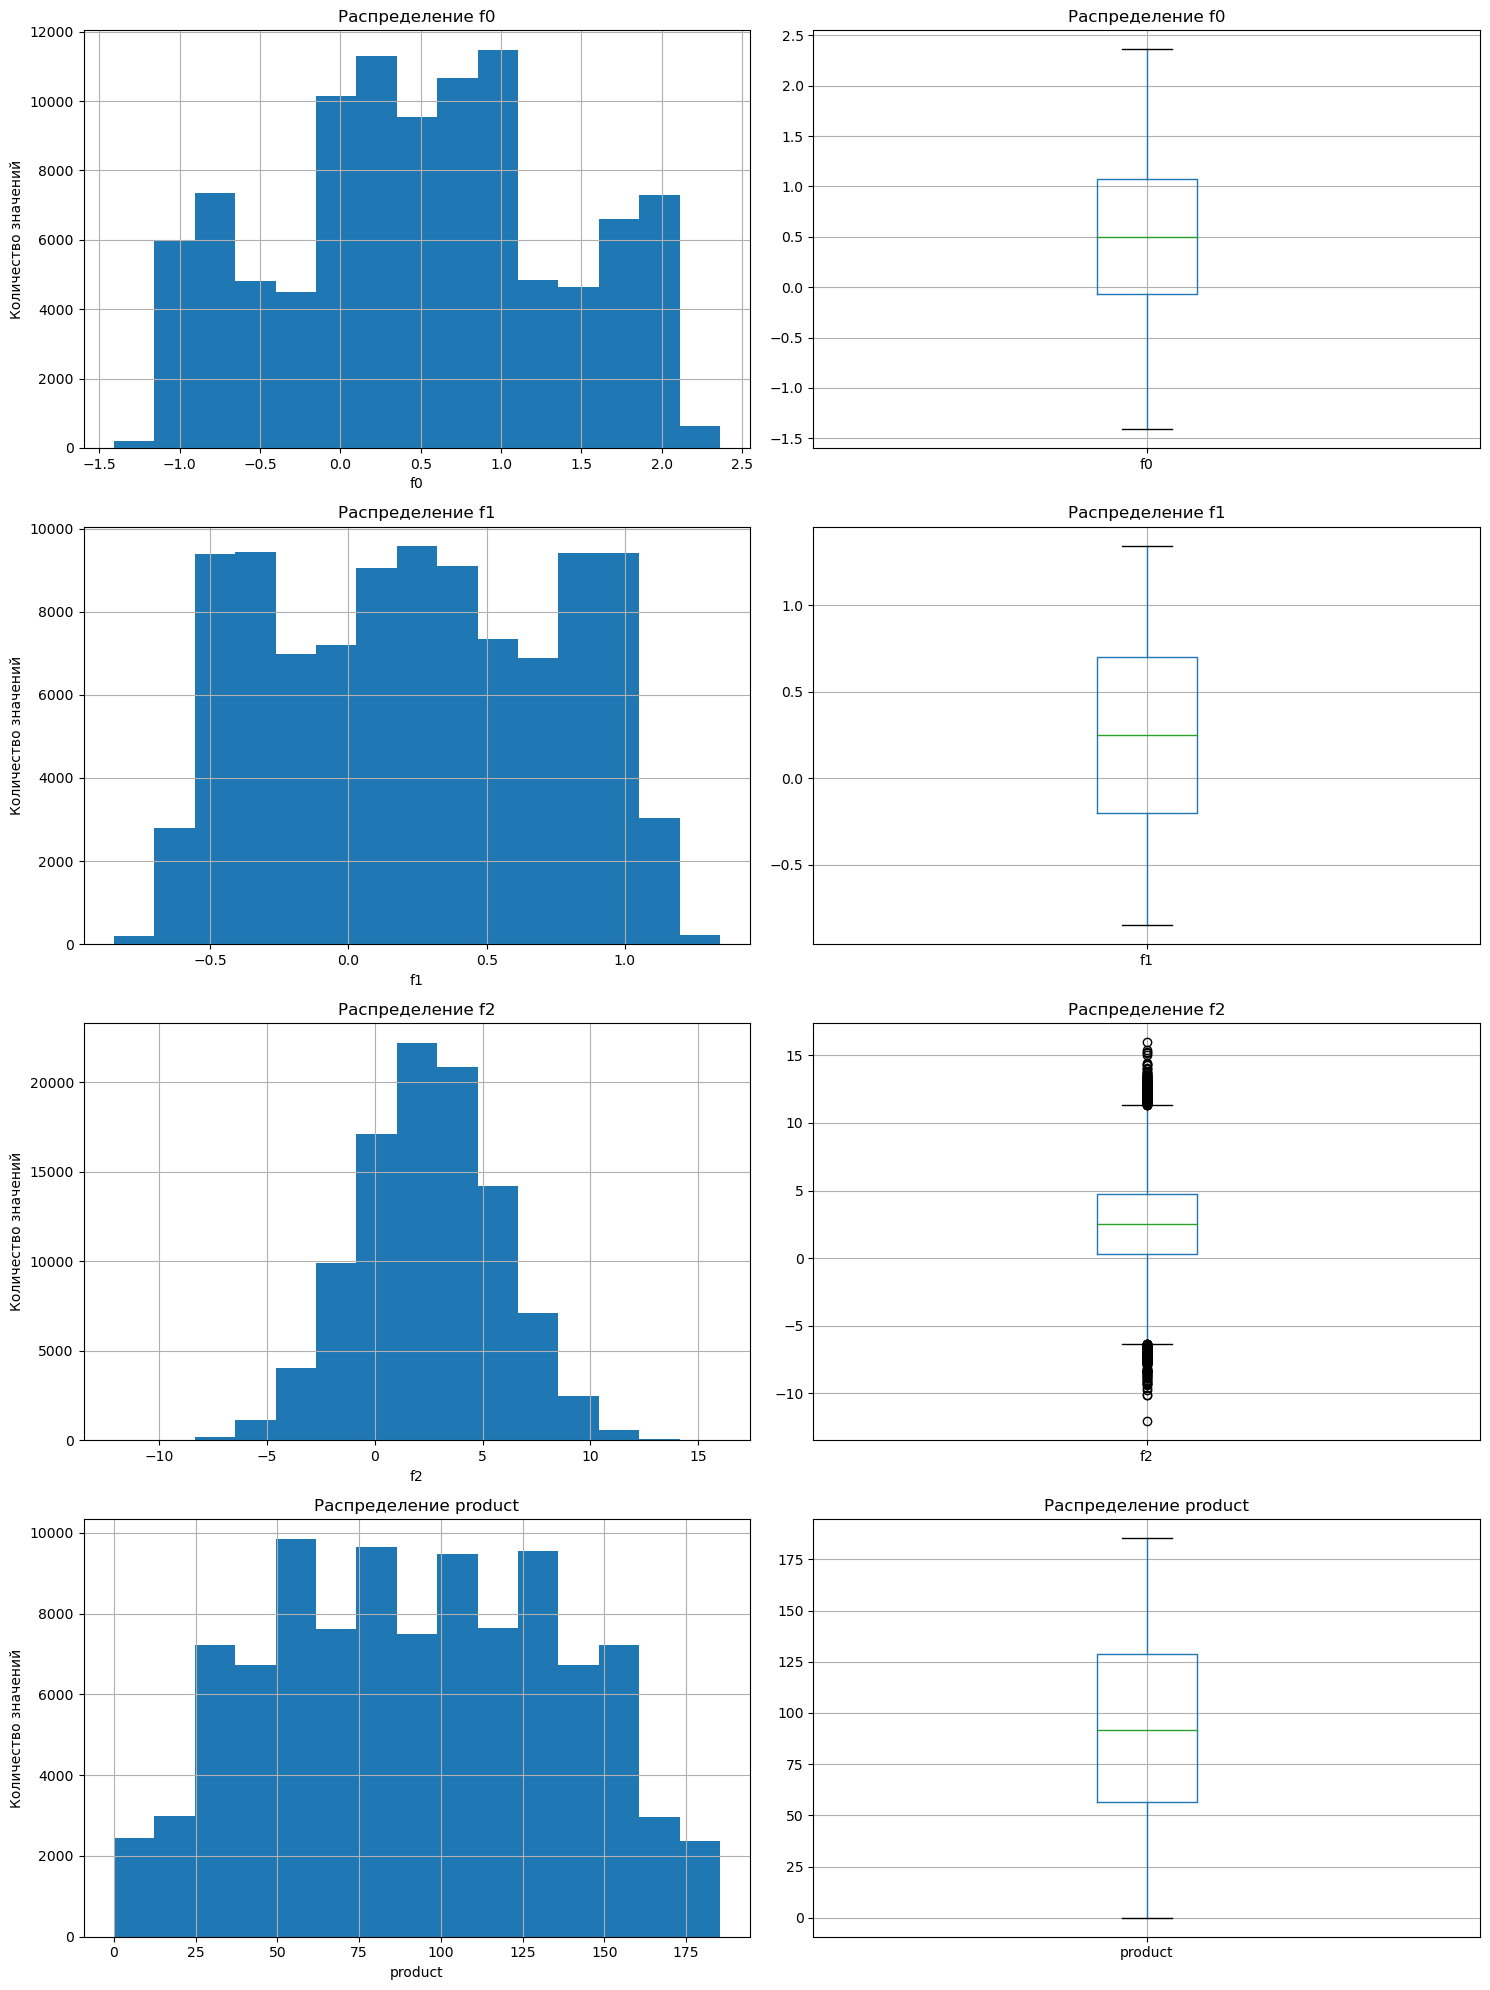

In [10]:
plots_hist_box(geo_data_0)

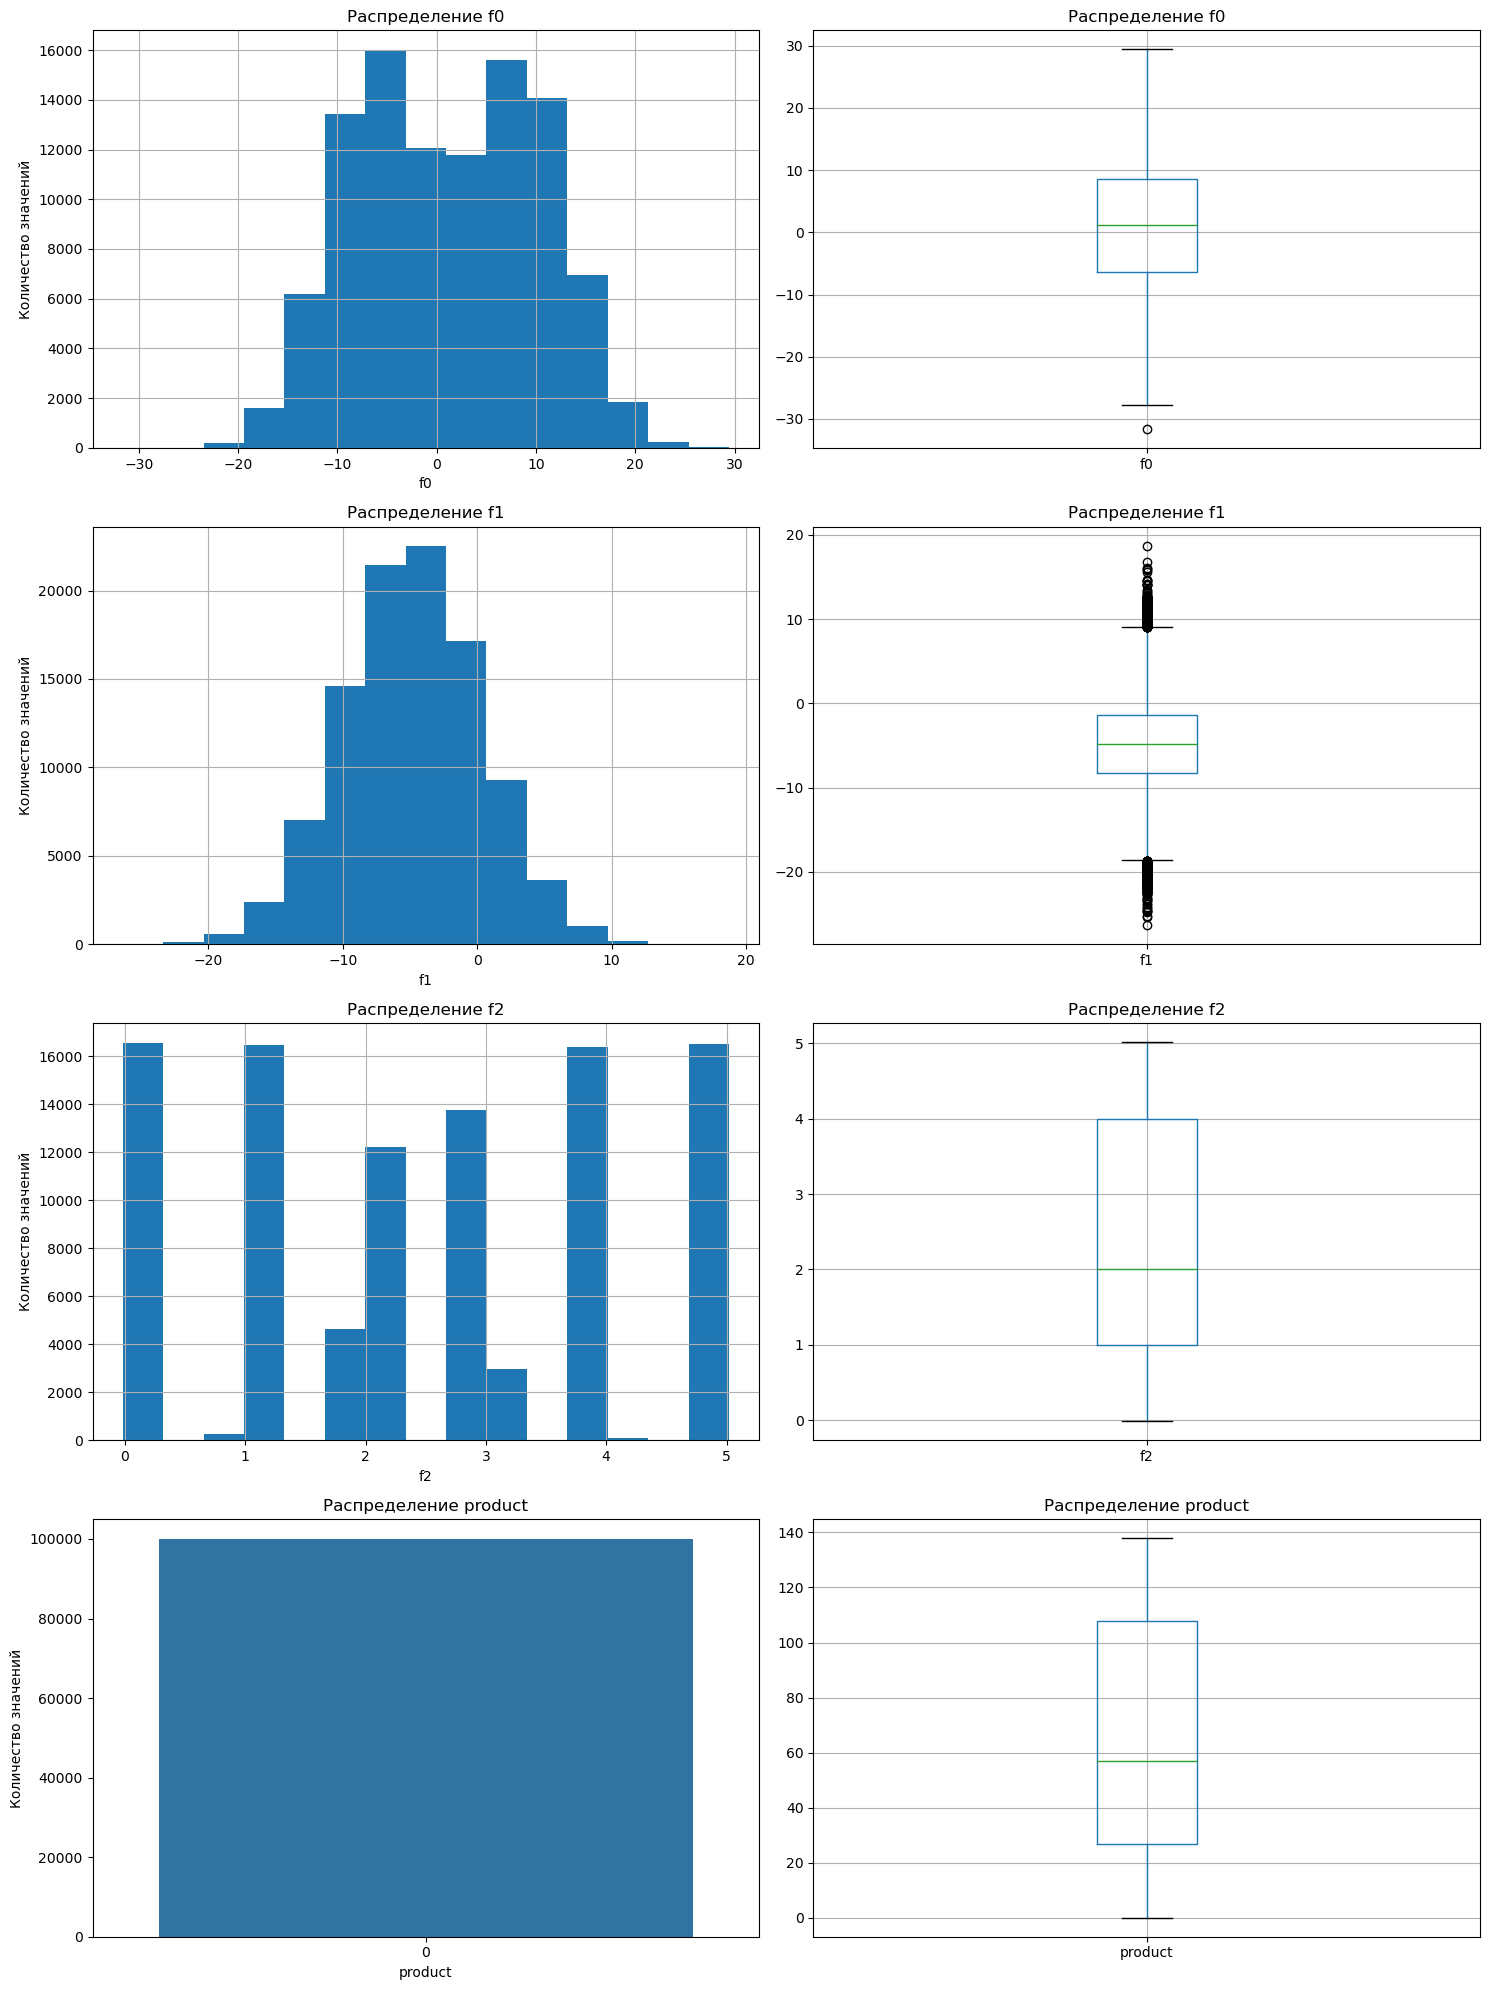

In [11]:
plots_hist_box(geo_data_1)

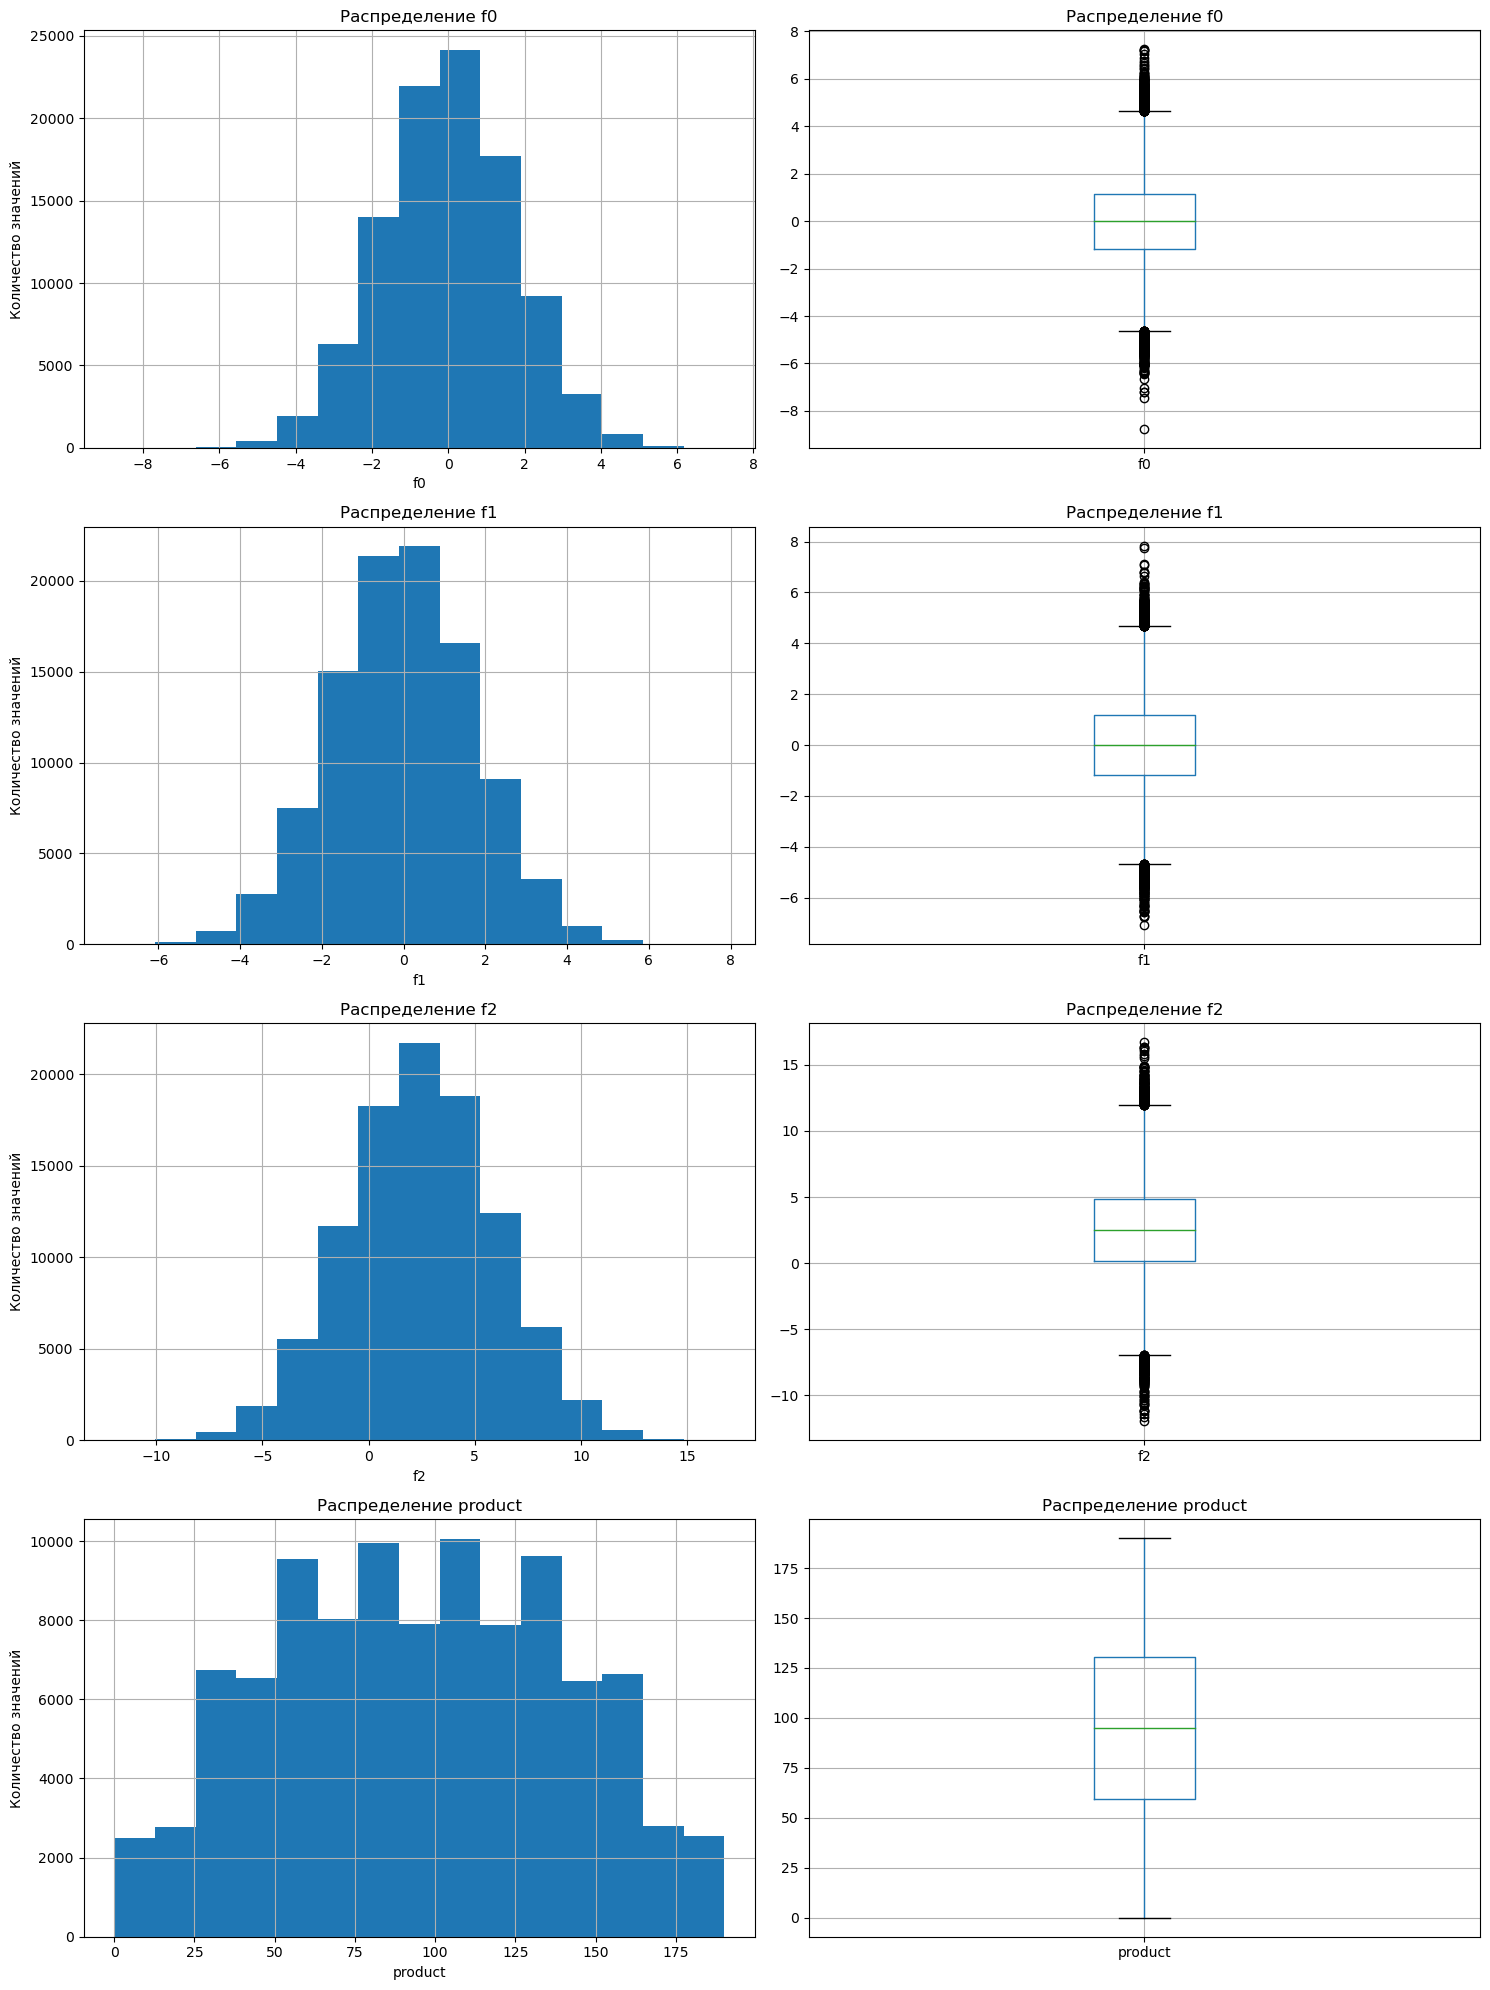

In [12]:
plots_hist_box(geo_data_2)

В целом данные нормально распределены или близки к нормальному распределению по параметрам. Анализируя графики, складывается ощущение что датасет для второго региона имеет сильные искажения или ошибки в данных. Больше всего это сказывается на параметрах f2 и product. <br><br>
Говоря о датасетах 1-ого и 3-его регионах, стоит заметить что сильных выбросов в данных не обнаружено и данные выглядят хорошо.<br><br>
Подробнее рассмотрим product.

### Распределение объема скважин

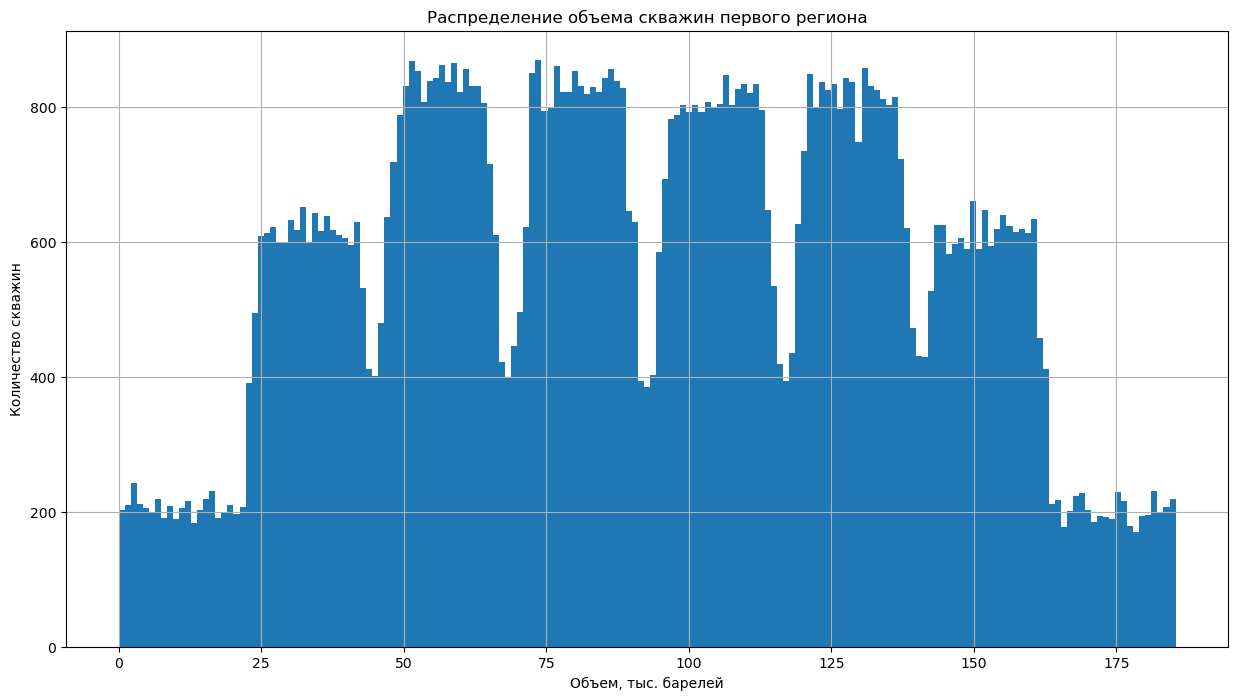

In [13]:
plt.figure(figsize=(15,8))
geo_data_0['product'].hist(bins=175)
plt.xlabel('Объем, тыс. барелей')
plt.ylabel('Количество скважин')
plt.title('Распределение объема скважин первого региона')
plt.show()

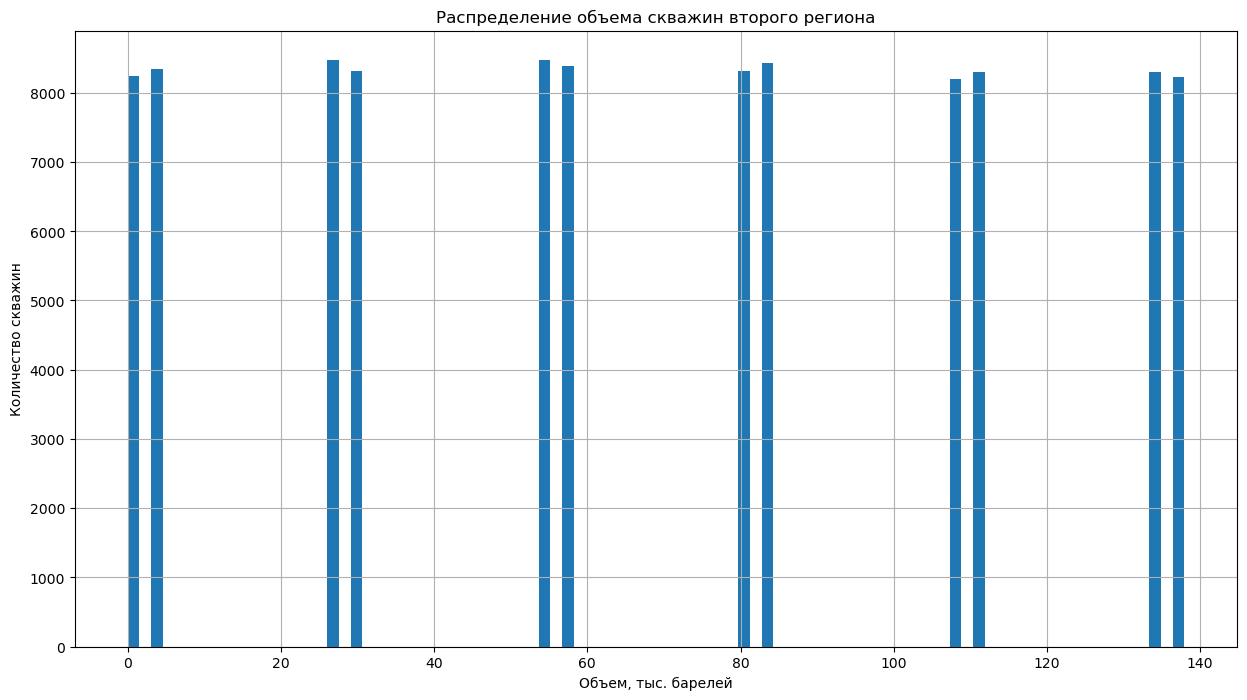

In [14]:
plt.figure(figsize=(15,8))
geo_data_1['product'].hist(bins=90)
plt.xlabel('Объем, тыс. барелей')
plt.ylabel('Количество скважин')
plt.title('Распределение объема скважин второго региона')
plt.show()

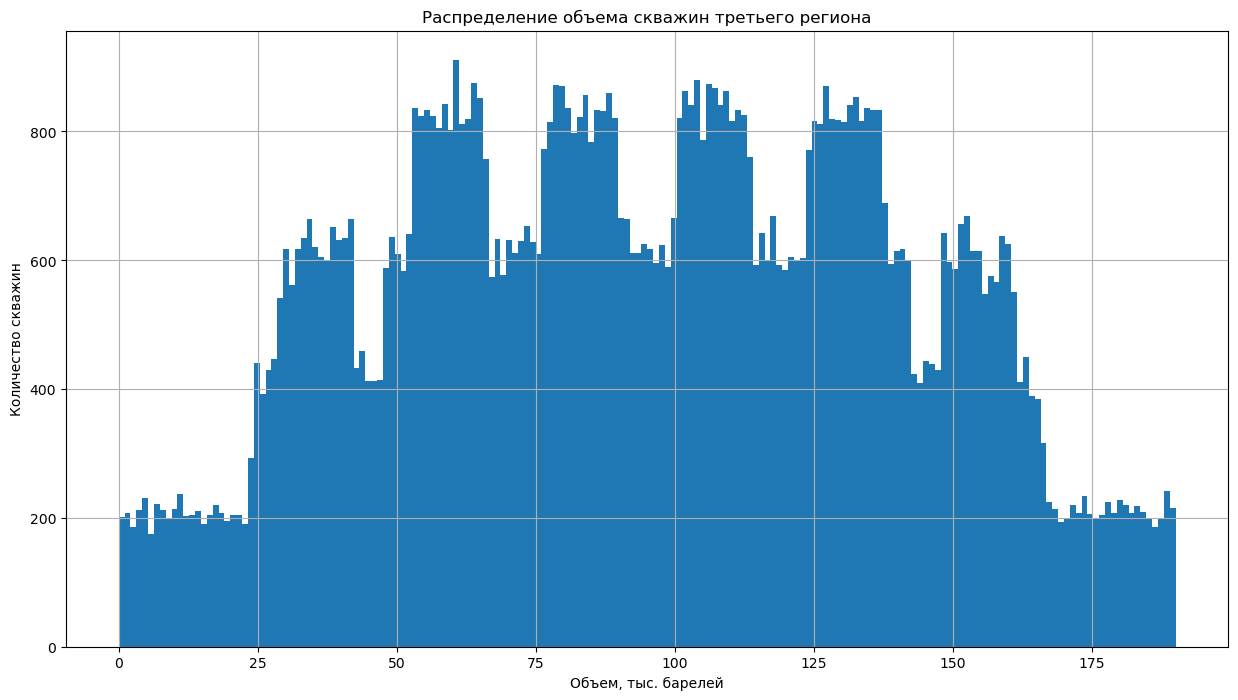

In [15]:
plt.figure(figsize=(15,8))
geo_data_2['product'].hist(bins=180)
plt.xlabel('Объем, тыс. барелей')
plt.ylabel('Количество скважин')
plt.title('Распределение объема скважин третьего региона')
plt.show()

### Корреляционный анализ

Так как объем данных большой и считает долго, возьмен образец данных.

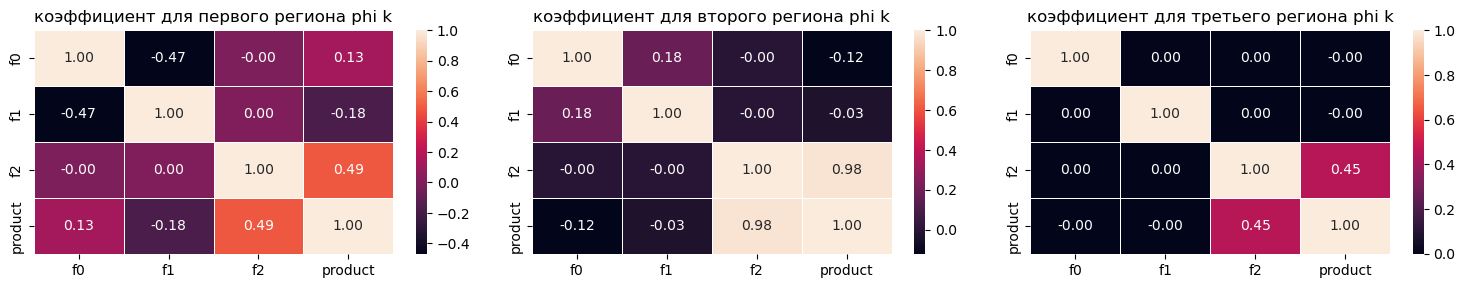

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(3, 3, 1)
plt.title('коэффициент для первого региона phi k')
corr_matrix0 = geo_data_0.drop(columns=(['id'])).corr(method='spearman');
sns.heatmap(corr_matrix0,
            xticklabels=corr_matrix0.columns.values,
            yticklabels=corr_matrix0.columns.values,
           fmt=".2f", annot=True, linewidth=.5);

plt.subplot(3, 3, 2)
plt.title('коэффициент для второго региона phi k')
corr_matrix1 = geo_data_1.drop(columns=(['id'])).corr(method='spearman');
sns.heatmap(corr_matrix1,
            xticklabels=corr_matrix1.columns.values,
            yticklabels=corr_matrix1.columns.values,
           fmt=".2f", annot=True, linewidth=.5);

plt.subplot(3, 3, 3)
plt.title('коэффициент для третьего региона phi k')
corr_matrix2 = geo_data_2.drop(columns=(['id'])).corr(method='spearman');
sns.heatmap(corr_matrix2,
            xticklabels=corr_matrix2.columns.values,
            yticklabels=corr_matrix2.columns.values,
           fmt=".2f", annot=True, linewidth=.5);
plt.tight_layout()
plt.show()

<s>Великолепная корреляция между целевым признаком и параметрами f0, f1, f2 в первом и третьем регионе.</s>

Судя по матрицам корреляции параметр f2 имеет заметную корреляцию с целевым признаком в первом и третьем регионе. (Второй не смотрим, он подозрительный) 

### Вывод:
Данные готовы к обучению и проверки модели.<br><br>

Во втором датасете обнаружено много месторождений с нулевым объемом, и все варианты значений укладывается в 12 значений. Сравнив распределение признаков с первым и третьим регионом то можно сказать что в данных какая-то ошибка либо они повреждены.

## Обучение и проверка модели

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

Колонка id не информативна и не будет участвовать в обучении модели. Удалим ее из каждого датасета.

In [17]:
geo_data_0.drop('id',inplace=True,axis=1)
geo_data_0.info()
geo_data_1.drop('id',inplace=True,axis=1)
geo_data_1.info()
geo_data_2.drop('id',inplace=True,axis=1)
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1 

Добавим функцию разбиения датасета на обучающую и валидационную выборки

In [18]:
def data_split(data, target, valid_size):
    # data - dataframe
    # target - target feature
    # valid_size - train and valid proportion
    features = data.drop([target] , axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=valid_size, random_state=RANDOM_STATE)
    
    return features_train, features_valid, target_train, target_valid

Категориальные признаки в даннных отсутствуют, имеются только количественные. Отмасштабируем их перед обучением модели. Для этого добавим функцию.

In [19]:
def data_split_scale(data, target, valid_size, cols_to_scale):
    features_train, features_valid, target_train, target_valid = data_split(data, target, valid_size)
    
    scaler = StandardScaler()
    scaler.fit(features_train[cols_to_scale])
    features_train_scaled = scaler.transform(features_train[cols_to_scale])
    features_valid_scaled = scaler.transform(features_valid[cols_to_scale])
    return features_train_scaled, features_valid_scaled, target_train, target_valid

Объявим функцию, которая на выходе выдаст нам валидационные и предсказанные значения

In [20]:
def make_model_get_result(data, target, valid_size, cols_to_scale):
    train_x, valid_x, train_y, valid_y = data_split_scale(data, target, valid_size, cols_to_scale)
    model = LinearRegression()
    model.fit(train_x, train_y)
    predict_y = model.predict(valid_x)
    return valid_y, predict_y

### Обучите модель и сделайте предсказания на валидационной выборке.

Далее работать будем с моделью линейной регрессии.

In [21]:
# Модель и предсказания для первого региона 
geo0_valid_y, geo0_predict_y = make_model_get_result(geo_data_0, 'product', 0.25, ['f0','f1','f2'])

In [22]:
# Модель и предсказания для второго региона
geo1_valid_y, geo1_predict_y = make_model_get_result(geo_data_1, 'product', 0.25, ['f0','f1','f2'])

In [23]:
# Модель и предсказания для второго региона
geo2_valid_y, geo2_predict_y = make_model_get_result(geo_data_2, 'product', 0.25, ['f0','f1','f2'])

### Сохраните предсказания и правильные ответы на валидационной выборке.

In [24]:
results_geo0 = pd.DataFrame({'real' : geo0_valid_y, 'predict' : geo0_predict_y})
results_geo1 = pd.DataFrame({'real' : geo1_valid_y, 'predict' : geo1_predict_y})
results_geo2 = pd.DataFrame({'real' : geo2_valid_y, 'predict' : geo2_predict_y})

display(results_geo0.head())
display(results_geo1.head())
display(results_geo2.head())

,real,predict
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


,real,predict
70156,53.906522,54.238152
42796,84.038886,83.217878
36723,3.179103,2.971467
79446,26.953261,25.916480
93328,110.992147,111.341137


,real,predict
2239,52.610856,112.561878
40967,52.273440,69.464073
86415,71.340473,69.866229
59788,162.937918,110.331048
37765,155.371552,95.123288


### Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

In [25]:
total_result = pd.DataFrame({'Параметр':['Сред. запас','Действ. общий запас','Предсказ. общий запас','RMSE'],
                             'Регион 1':[round(results_geo0.predict.mean(),3),
                                         round(results_geo0.real.sum(),3),
                                         round(results_geo0.predict.sum(),3),
                                         round(mean_squared_error(results_geo0.real, results_geo0.predict)**0.5,3)],
                             'Регион 2':[round(results_geo1.predict.mean(),3),
                                         round(results_geo1.real.sum(),3),
                                         round(results_geo1.predict.sum(),3),
                                         round(mean_squared_error(results_geo1.real, results_geo1.predict)**0.5,3)],
                             'Регион 3':[round(results_geo2.predict.mean(),3),
                                         round(results_geo2.real.sum(),3),
                                         round(results_geo2.predict.sum(),3),
                                         round(mean_squared_error(results_geo2.real, results_geo2.predict)**0.5,3)]
                            })

display(total_result)

,Параметр,Регион 1,Регион 2,Регион 3
0,Сред. запас,92.593,68.770,95.088
1,Действ. общий запас,2301964.919,1719290.606,2368723.968
2,Предсказ. общий запас,2314814.195,1719248.786,2377188.203
3,RMSE,37.579,0.890,39.958


### Проанализируйте результаты.

Для того чтобы понять, насколько хорошо справилась модель, учтем как метрику, так и общие запасы сырья в регионе. <br><br>
Если обратиться к метрике RMSE то наилучшим образом модель линейной регрессии обучилась на данных второго региона, а корень из среднеквадратичной ошибки составил - 0.893, далее по качеству идет первый и третий регион с значениями RMSE 37.579 и 40.030 соответственно.
<br><br>
Однако, если чуть отойти от задания и глянуть насколько точно модель предсказала общий запас сырья в регионах, то увидим, что ближе всего к реальности получилось в первом регионе, далее третий и замыкает второй. Вцелом ничего удивительного, так как в датасете по второму региону много пропусков в записях о количестве сырья в месторождениях. 
<br><br>
Также следует отметить что средний запас предсказанного сырья почти одинаковый для каждого региона.

### Вывод:

Исходя из проведенного анализа и обучения и проверки модели, можно сделать вывод что перспективными для выбора под разработку являются первый и третий регионы. Данные второго региона аномальны и, наверняка, содержат ошибку. С текущими данными по второму региону рискованно делать его приорететным вариантом для проведения разработки и добычи.
<br><br>
Говоря о модели, можно сказать что результат получился удовлетворительным.

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных.

Все ключевые моменты мы зафексировани в табличке, вспомним, что там получилось

In [26]:
display(total_result)

,Параметр,Регион 1,Регион 2,Регион 3
0,Сред. запас,92.593,68.770,95.088
1,Действ. общий запас,2301964.919,1719290.606,2368723.968
2,Предсказ. общий запас,2314814.195,1719248.786,2377188.203
3,RMSE,37.579,0.890,39.958


Бюджет на разработку скважин в регионе — 10 млрд рублей.<br><br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br><br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br><br>
Далее деньги будем считать в миллионах рублей, чтобы не путаться в нулях.

In [27]:
BUDGET = 10e+03 # Бюджет на разработку скважин в регионе 
RESEARCH_FIELDS = 500 # Точек для исследования
SELECTED_FIELDS = 200 # Точек для разработки
PRODUCT_PRICE = 0.45 # Цена за тыс. барелей

### Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 

А сколько в среднем должен быть запас месторождения, чтобы выйти в 0?

In [28]:
print('Средней объем месторождения для безубыточной добычи:', round((BUDGET/SELECTED_FIELDS)/PRODUCT_PRICE,3), 'тыс. баррелей')

Средней объем месторождения для безубыточной добычи: 111.111 тыс. баррелей


Так, а сколько всего нужно добыть в регионе чтобы выйти в ноль? 

In [29]:
print('Средней объем месторождения для безубыточной добычи:', round(BUDGET/PRODUCT_PRICE,3), 'тыс. баррелей')

Средней объем месторождения для безубыточной добычи: 22222.222 тыс. баррелей


Чуть больше 22 миллионов баррелей, много.

### Напишите выводы по этапу подготовки расчёта прибыли.

Сравнив данные видно, что среднего запаса скважин недостаточно чтобы выйти в окупаемость. Поэтому нам предстоит выбрать только самые большие скважины.

## Расчёт прибыли и рисков 

### Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [30]:
def fields_profit(target, predict):
    # Выберите скважины с максимальными значениями предсказаний. 
    best = predict.sort_values(ascending=False).head(SELECTED_FIELDS)    
    #Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    total_profit = target.loc[best.index].sum()
    #Рассчитайте прибыль для полученного объёма сырья.
    return (total_profit*PRODUCT_PRICE) - BUDGET

## Посчитайте риски и прибыль для каждого региона:

### Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [31]:
# Функция применяет технику Bootstrap согласно заданию, а возвращает 
# среднюю прибыль, квантиль 2,5% и 97,5%, а также процент риска. Возвращаемые значения выводятся на экран
def bootstrap_1000(target, predict):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(random_state=RANDOM_STATE, n=RESEARCH_FIELDS, replace=True)
        predict_sample = predict[target_sample.index]
        profit = fields_profit(target, predict_sample)
        #print(profit)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    print('Средняя прибыль по региону:',round(average,3),'млн. рублей')
    print('95%-й доверительный интервал:',round(lower,3),'-',round(upper,3),'млн. рублей')
    print('Процент риска',round(risk*100,2),'%')
    sns.distplot(values)
    return average, lower, upper, risk

### Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Применим функцию к полученным ранее данным

Результаты по региону 1
Средняя прибыль по региону: 394.284 млн. рублей
95%-й доверительный интервал: -69.451 - 915.496 млн. рублей
Процент риска 6.1 %

Результаты по региону 2
Средняя прибыль по региону: 454.736 млн. рублей
95%-й доверительный интервал: 61.072 - 855.914 млн. рублей
Процент риска 0.7 %

Результаты по региону 3
Средняя прибыль по региону: 353.664 млн. рублей
95%-й доверительный интервал: -162.651 - 847.762 млн. рублей
Процент риска 7.6 %


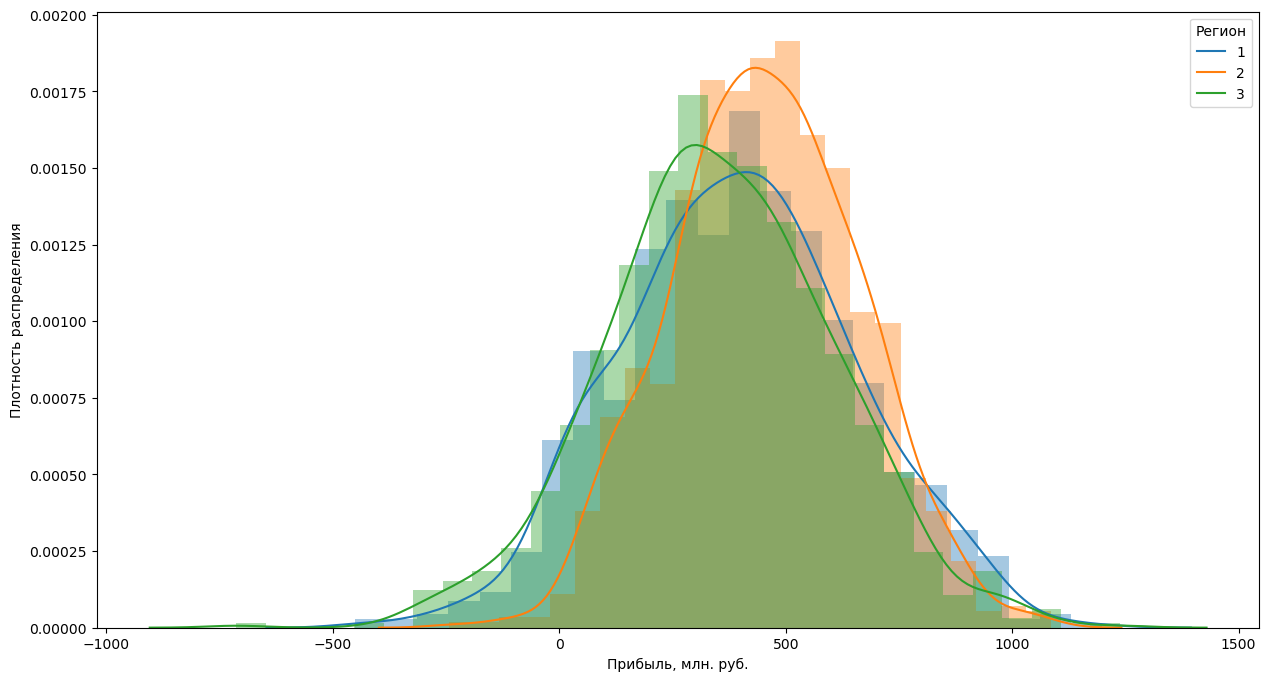

In [32]:
plt.figure(figsize=(15,8))

print('Результаты по региону 1')
bootstrap_1000(results_geo0.real,results_geo0.predict)
print('\nРезультаты по региону 2')
bootstrap_1000(results_geo1.real,results_geo1.predict)
print('\nРезультаты по региону 3')
bootstrap_1000(results_geo2.real,results_geo2.predict)

plt.xlabel('Прибыль, млн. руб.')
plt.ylabel('Плотность распределения')
plt.legend(['1','2','3'],title="Регион")
plt.show()

### Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

Лучший результат оказался во втором регионе, но как говорили ранее. Данные в датасете выглядят подозрительно, а также присутствуют множественные пропуски в колонке product.<br><br>
В итоге, первая модель предоставляет минимальный процент риска - 7.5%, что соответсвует и самую большую среднюю прибыль по региону в 380 млн. рублей.


## Вывод
В ходе работы были загруженны и подготовлены данные, обучены и проверены модели для каждого из трех регионов, проведена подготовка и рассчитаны риски и прибыль для регионов.<br><br>
Цели работы частично достигнуты, так как ни одна из моделей не смогла гарантировать риск равным или менее 2.5%. Но наилучшим вариантом для разработки является первый регион с наибольшей средней прибылью по региону.


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован